# Трек No 1. Задача 2.  
## Выявление характерных режимов работы оборудования

В рамках задачи был реализован pipeline, позволяющий решить задачу кластеризации на предоставленном наборе данных.  
В данном ноутбуке представлен пример работы фреймворка на втором тренировочном наборе данных  
  
Решение на тестовом наборе данных представлено в ноутбуке **solution.ipynb**

Решение реализовано на **python 3.8.15**

### Step 0. Подготовка

Устанавливаем необходимые зависимости

In [3]:
!pip install -r ./requirements.txt

  Using cached scikit_learn-1.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 8.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pm4py 2.2.7.1 requires networkx, which is not installed.
karateclub 1.2.2 requires gensim>=4.0.0, which is not installed.
karateclub 1.2.2 requires networkx, which is not installed.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you have scipy 1.9.3 which is incompatible.


Импорт пайплайна и сопутствующих библеотек для отрисовки графиков

In [1]:
%load_ext autoreload
%autoreload 2
import pipeline
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Создание объекта Dataset

In [2]:
dataset = pipeline.Dataset()
_ = dataset.load(
    path='./data/dataset/Задача 2. Датасет 2. Тренировочный.csv', 
    sep=';', 
    encoding='cp1251'
)
_ = dataset.prepare(
    date='Параметр', 
    target='РЕЖИМ', 
    drop_rows=[0], 
    drop_cols=[-2],
    dropna=True
)

In [3]:
dataset.data.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f329,f330,f331,f332,f333,f334,f335,f336,f337,target
date_col,,,,,,,,,,,,,,,,,,,,,
01.07.2022 0:00,2.005208,0.203984,-0.000182,0.164062,-0.001823,0.751591,2.517361,38.63533,3007.434,38.98186,...,118.5149,252.0879,2.343750,72.46094,38.97569,-118.5185,0.347222,98.52431,98.57639,1.0
01.07.2022 0:01,2.005208,0.202708,0.000000,0.181380,-0.008203,0.746528,2.512153,38.64738,3006.460,39.01608,...,118.5149,252.7784,2.365451,72.46817,39.35185,-118.5185,0.347222,98.52431,98.57639,1.0
01.07.2022 0:02,2.005208,0.196693,0.000000,0.180286,-0.002734,0.762442,2.510417,38.59549,3006.403,38.93647,...,118.5149,253.6364,2.329282,72.44647,41.91262,-118.5185,0.347222,98.52431,98.57639,1.0


### Step 1. Отбор значимых признаков

Параллельное обучение набора алгоритмов кластеризации.  
На *каждом* признаке в отдельности обучается алгоритм **KMeans** и производится предсказание кластеров

In [4]:
model = pipeline.ParallelKMeans()
preds = model.iterfit(
    dataset,
    k=10,
    n_jobs=1
)

  0%|          | 0/337 [00:00<?, ?it/s]

Попарно для каждого набора лэйблов считается метрика **v_score**

In [5]:
v_score = pipeline.metrics.v_measure_parallel(data=preds, n_jobs=-1)

  0%|          | 0/337 [00:00<?, ?it/s]

<AxesSubplot:>

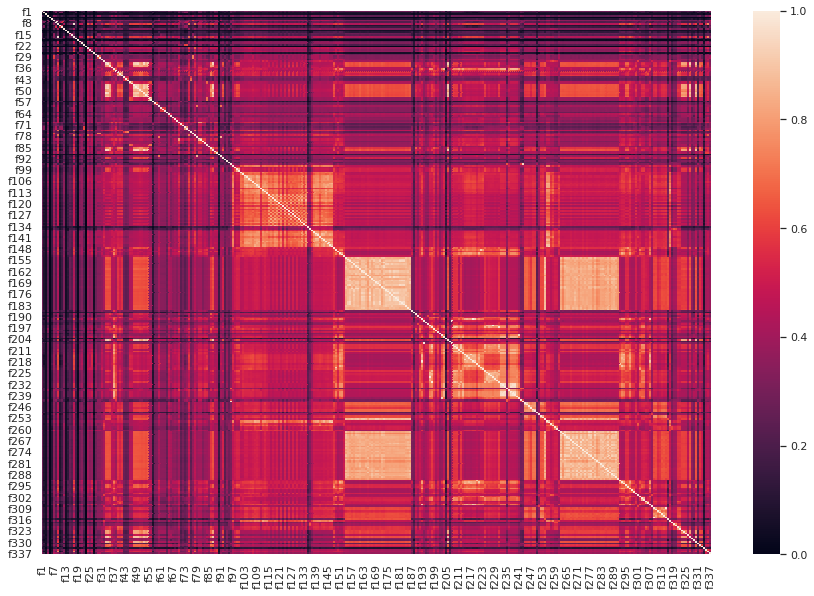

In [6]:
fig, ax = plt.subplots(figsize=(15,10))     
sns.heatmap(v_score, vmin=0, vmax=1, ax=ax)

Отбираются признаки с наибольшим значением v_score (значение **больше медианы** распределения метрики).  
Таким образом отбирается половина изначального количества признаков.

In [7]:
features_v_score = v_score.sum(axis=1)
top_features = list(features_v_score[features_v_score > features_v_score.median()].index)

### Step 2. Оптимизация количества кластеров

На отобранном наборе признаков строится кривая Элбоу и выбирается наилучшее k

  0%|          | 0/38 [00:00<?, ?it/s]

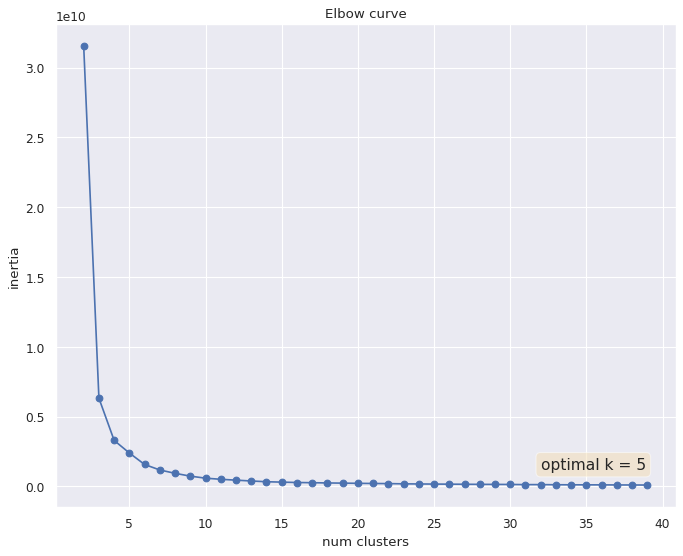

In [8]:
best_k = model.elbow(dataset, features=top_features, k_list=list(range(2, 40)))

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(model.inertia['k'], model.inertia['inertia'], '-o', )
plt.xlabel('num clusters')
plt.ylabel('inertia')
plt.title('Elbow curve')
plt.text(32,1e9*1.23, f'optimal k = {best_k}', fontsize=14, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

Для найденного k и отобранного набора признаков выделяются две главные компонены алгоритмом PCA и отбирается более подходящее значение k

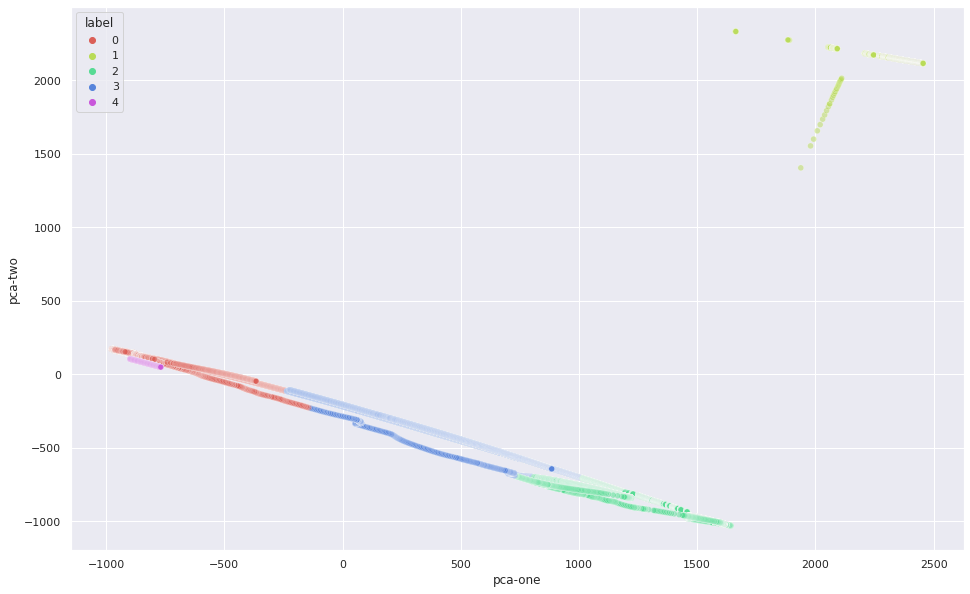

In [9]:
model.plot(dataset, features=top_features, k=best_k)

Последовательной отрисовкой графиков можно убедитьс, что лучшее количество кластеров **15**

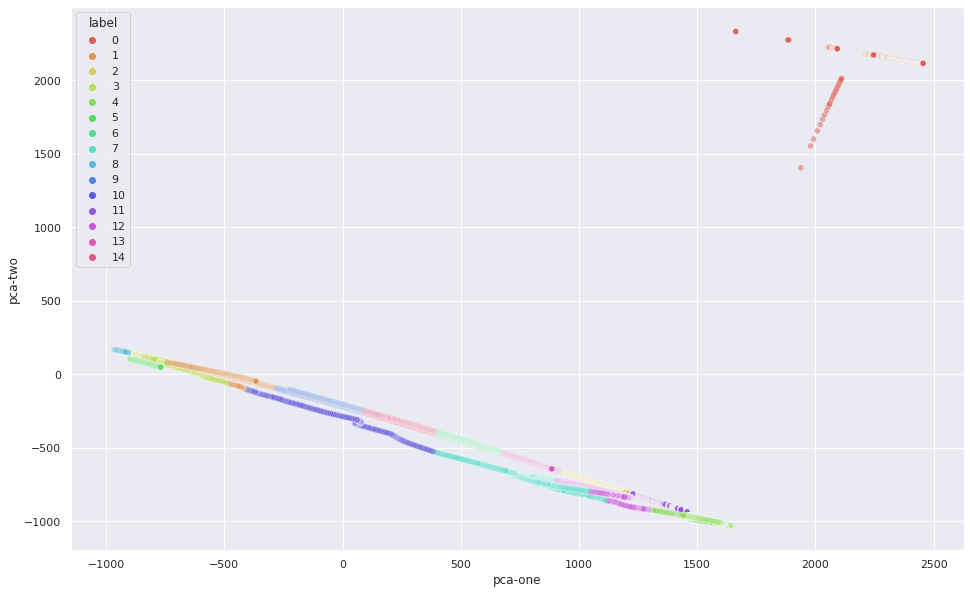

In [10]:
model.plot(dataset, features=top_features, k=15)

### Step 3. Результат

На отобранных признаков с выбранным количеством кластеров строится финальная модель KMeans.  
Итоговые предсказания записываются в файл **solution.csv**

In [22]:
top_features = list(features_v_score[features_v_score > features_v_score.median() - 0.1*features_v_score.std()].index)

In [25]:
predict = model.fit_predict(data=dataset, k=15, save=True)

Распределение событий по найденным кластерам

In [12]:
predict.value_counts()

3     14413
8      9262
4      4893
0      3146
13     1350
11     1261
2      1181
12     1165
6      1122
14      874
7       757
9       677
1       436
10      215
5       108
Name: predict, dtype: int64

Запись решения в файл

In [13]:
# dataset.save(
#     predict.reset_index(drop=False), 
#     path='./data/solution/sulution.csv',
#     sep=';', 
#     encoding='cp1251'
# )

Результирующая метрика **v_score**

In [26]:
from sklearn.metrics import v_measure_score
print("V_SCORE: {}".format(v_measure_score(dataset.data['target'].values, predict.values)))

V_SCORE: 0.5847932709421076


In [15]:
from sklearn.metrics import v_measure_score
print("V_SCORE: {}".format(v_measure_score(dataset.data['target'].values, predict.values)))

V_SCORE: 0.6332179523450594
